In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
#load datasets. I have 5 files each one is a season of data. 18-19, 19-20, 20-21, 21-22, and 22-23 

pd.set_option('mode.chained_assignment', None)

file_names = ['WyScoutData.xlsx', 'WyScoutData2.xlsx', 'WyScoutData3.xlsx', 'WyScoutData4.xlsx', 'WyScoutData5.xlsx']
dataframes = [pd.read_excel(file, engine='openpyxl') for file in file_names]

In [4]:
# Assign test_data and train_data
test_data_raw = dataframes[0]  # WyScoutData.xlsx
train_data_raw = pd.concat(dataframes[1:], ignore_index=True)  # WyScoutData2.xlsx, WyScoutData3.xlsx, WyScoutData4.xlsx, WyScoutData5.xlsx
pd.set_option('display.max_columns', None)


In [5]:
# Data Preprocessing Function
def preprocess_data(raw_data):
    player_stats = raw_data.copy()
    player_stats = player_stats[player_stats['Minutes played'] >= 900]
    player_stats['Prevented goals'] = player_stats['Prevented goals'].fillna(0)
    position_columns = player_stats['Position'].str.split(',', expand=True)
    position_columns.columns = [f'Position {i+1}' for i in range(position_columns.shape[1])]
    player_stats = pd.concat([player_stats, position_columns], axis=1)
    player_stats = player_stats.drop(['Position 2', 'Position 3'], axis=1)
    columns = player_stats.columns.tolist()
    columns.remove('Position 1')
    position_index = columns.index('Position')
    columns.insert(position_index + 1, 'Position 1')
    player_stats = player_stats[columns]
    position_replacements = {
        'LWF': 'LW', 'RWF': 'RW', 'RCMF': 'CM', 'LCMF': 'CM', 'LDMF': 'DMF',
        'RDMF': 'DMF', 'LCB': 'CB', 'RCB': 'CB', 'RAMF': 'AMF', 'LAMF': 'AMF'
    }
    player_stats['Position 1'] = player_stats['Position 1'].replace(position_replacements)
    player_stats = player_stats.drop(['Position', 'Contract expires', 'Minutes played', 'Birth country'], axis=1)
    return player_stats


In [6]:
# Preprocessing
train_data = preprocess_data(train_data_raw)
test_data = preprocess_data(test_data_raw)

In [7]:
# Feature Selection and Scaling
X_train = train_data.drop(['Player', 'Team', 'Position 1'], axis=1)
y_train = train_data['Position 1']
X_test = test_data.drop(['Player', 'Team', 'Position 1'], axis=1)
y_test = test_data['Position 1']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Label encoding the target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Define the model using TensorFlow/Keras with the best hyperparameters
model = Sequential()

# Input layer
model.add(Dense(96, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.15))

# First hidden layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))  

# Note: The best hyperparameters indicate only 1 hidden layer (num_layers: 1),

# Output layer
model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0004997443410706613), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train_encoded, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
220/220 [==============================] - 1s 3ms/step - loss: 1.2509 - accuracy: 0.5901 - val_loss: 0.7558 - val_accuracy: 0.7302
Epoch 2/100
220/220 [==============================] - 0s 2ms/step - loss: 0.7739 - accuracy: 0.7242 - val_loss: 0.6326 - val_accuracy: 0.7547
Epoch 3/100
220/220 [==============================] - 0s 2ms/step - loss: 0.6807 - accuracy: 0.7455 - val_loss: 0.5897 - val_accuracy: 0.7644
Epoch 4/100
220/220 [==============================] - 0s 2ms/step - loss: 0.6490 - accuracy: 0.7539 - val_loss: 0.5794 - val_accuracy: 0.7684
Epoch 5/100
220/220 [==============================] - 0s 2ms/step - loss: 0.6165 - accuracy: 0.7649 - val_loss: 0.5618 - val_accuracy: 0.7809
Epoch 6/100
220/220 [==============================] - 0s 2ms/step - loss: 0.5941 - accuracy: 0.7714 - val_loss: 0.5489 - val_accuracy: 0.7803
Epoch 7/100
220/220 [==============================] - 0s 2ms/step - loss: 0.5848 - accuracy: 0.7758 - val_loss: 0.5520 - val_accuracy: 0.7735

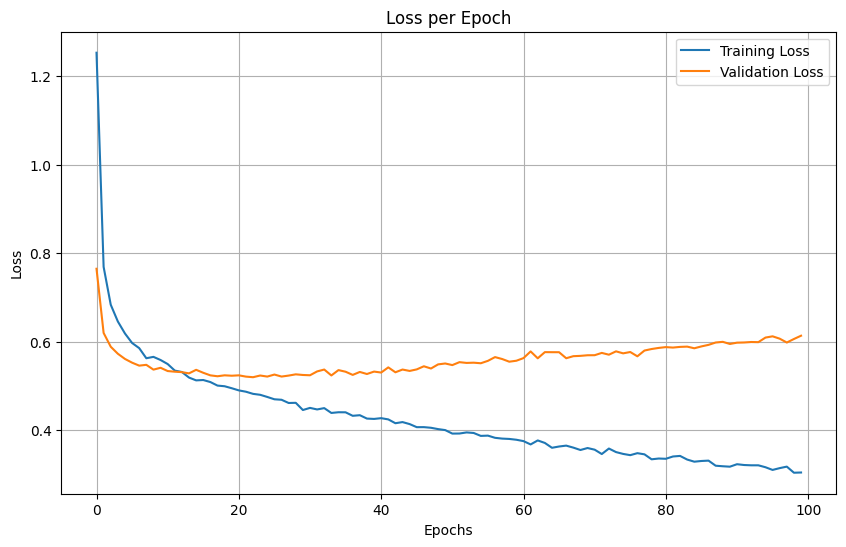

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Predictions
predicted_probabilities = model.predict(X_test_scaled)
test_predictions_tf = np.argmax(predicted_probabilities, axis=1)
test_predictions_tf_labels = le.inverse_transform(test_predictions_tf)

68/68 [==============================] - 0s 935us/step


In [20]:
# Exporting Results with All Columns from Test Data
output_df = test_data.copy()
output_df['Predicted Position'] = test_predictions_tf_labels
output_df.to_csv('predicted_positions_with_all_metrics.csv', index=False, encoding='utf-8')

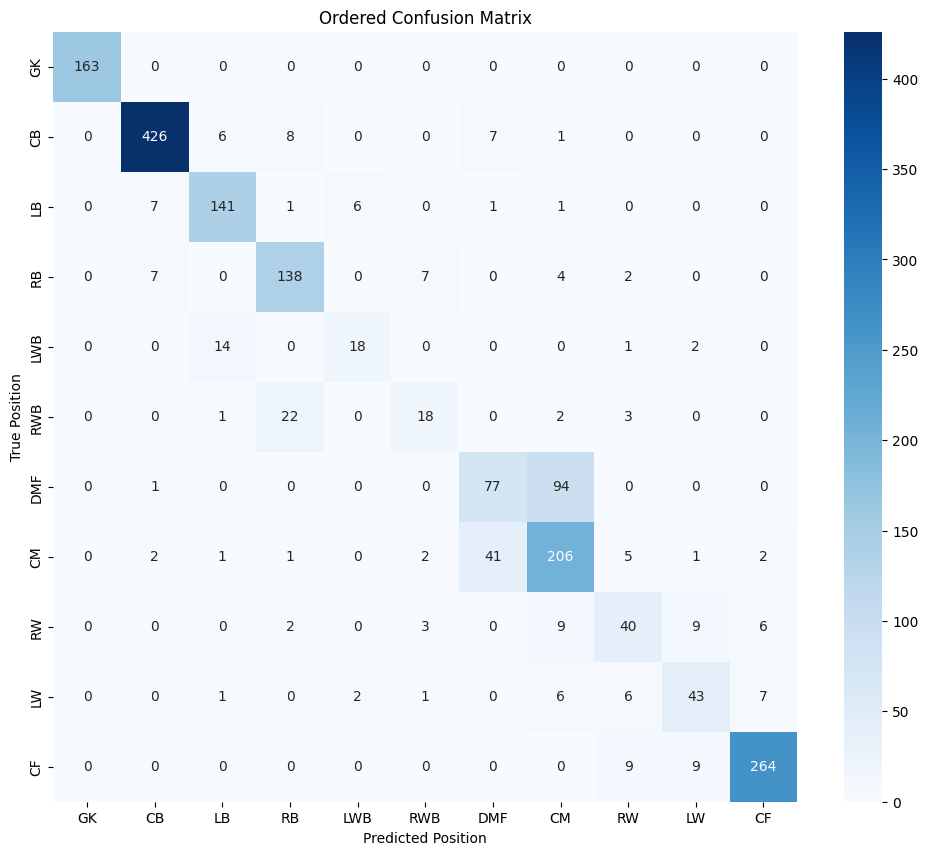

In [21]:
# Define the desired order for positions
position_order = ['GK', 'CB', 'LB', 'RB', 'LWB', 'RWB', 'DMF', 'CM', 'RW', 'LW', 'CF']

# Generate confusion matrix with ordered labels
cm = confusion_matrix(y_test, test_predictions_tf_labels, labels=position_order)

# Plotting the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=position_order, yticklabels=position_order)
plt.xlabel('Predicted Position')
plt.ylabel('True Position')
plt.title('Ordered Confusion Matrix')
plt.show()

In [12]:
from keras_tuner import HyperModel

class PlayerPositionHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units_input', min_value=64, max_value=256, step=32),
                        activation='relu', input_shape=(X_train_scaled.shape[1],)))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.05)))
        for i in range(hp.Int('num_layers', 1, 4)):
            model.add(Dense(units=hp.Int(f'units_{i}', min_value=64, max_value=256, step=32), activation='relu'))
            model.add(Dropout(rate=hp.Float(f'dropout_{i+1}', min_value=0.0, max_value=0.5, step=0.05)))
        model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))
        model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                      loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

In [13]:
from keras_tuner.tuners import Hyperband

hypermodel = PlayerPositionHyperModel()

tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=100,
    directory='hyperband',
    project_name='player_position'
)

INFO:tensorflow:Reloading Tuner from hyperband\player_position\tuner0.json


In [14]:
tuner.search(X_train_scaled, y_train_encoded, epochs=100, validation_split=0.2)

Trial 254 Complete [00h 00m 45s]
val_accuracy: 0.7985202074050903

Best val_accuracy So Far: 0.8030734062194824
Total elapsed time: 00h 26m 18s
INFO:tensorflow:Oracle triggered exit


In [16]:
tuner.results_summary()


Results summary
Results in hyperband\player_position
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0208 summary
Hyperparameters:
units_input: 96
dropout_1: 0.15000000000000002
num_layers: 1
units_0: 128
learning_rate: 0.0004997443410706613
units_1: 192
dropout_2: 0.30000000000000004
units_2: 160
dropout_3: 0.4
units_3: 96
dropout_4: 0.15000000000000002
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0207
Score: 0.8030734062194824

Trial 0242 summary
Hyperparameters:
units_input: 256
dropout_1: 0.4
num_layers: 3
units_0: 64
learning_rate: 0.0006314772413787091
units_1: 64
dropout_2: 0.0
units_2: 160
dropout_3: 0.45
units_3: 64
dropout_4: 0.45
tuner/epochs: 34
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.8019351363182068

Trial 0250 summary
Hyperparameters:
units_input: 64
dropout_1: 0.30000000000000004
num_layers: 4
units_0: 128
learning_rate: 0.0011941292372353927
units_1: 64
dropout_2: 0.2
uni